# Spectral fitting 
Demonstration of how to fit a spectrum for the example described in `response_demo.ipynb` where an instrument response was generated for a simple toy detector.

We will look at two different methods for comparison, both using [Stan](https://mc-stan.org).

In [16]:
import numpy as np
import h5py
import stan_utility
from matplotlib import pyplot as plt
from instrument_response.detector import Response

We have some data detected by our toy detector. We think it comes from a power law (this is our model), and under this assumption, we want to fit for the normalisation, $N$, and spectral index, $\alpha$, of this model (the parameters). In order to compare our model with data, we will use the response generated in `response_demo.ipynb`.

In [9]:
# Load response
response_file = 'output/response_sim.h5'
with h5py.File(response_file, 'r') as f:
    initial_energy = f['initial_energy'].value
    true_energy = f['true_energy'].value
    detected_energy = f['detected_energy'].value
    effective_area_max = f['effective_area_maximum'].value
response = Response(initial_energy, true_energy, detected_energy, effective_area_max)

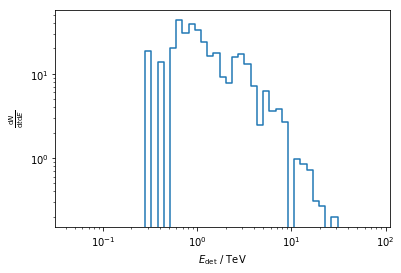

In [14]:
# Have a look at the data 
data_file = 'output/data.h5'

with h5py.File(data_file, 'r') as f:
    detected_energy = f['detected_energy'].value

channels = response.detected_energy_bins
dE = np.diff(channels)

dN_dt, _ = np.histogram(detected_energy, bins=channels)
dN_dtdE = dN_dt / dE

fig, ax = plt.subplots()
ax.step(channels[:-1], dN_dtdE, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}$');

## Standard approach
For this simple fitting example, we can fold our model spectrum through the instrument response to compare with the data in the fit, as described in `response_demo.ipynb`. We will use the Hamiltonian Monte Carlo approach implemented in `Stan` to determine which model parameters best describe our data.

The likelihood is:
$$
p(n | \alpha, N) = \prod_{i=1}^{N_{\rm{bins}}} \frac{s_i^{n_i}e^{-s_i}}{n_i!}
$$

where $s_i$ are the expected counts in each energy bin (or *channel*), computed by folding the model through the repsonse, and $n_i$ are the actual observed counts in each bin.